In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import os
import torch.nn.functional as F

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# from torchsummary import summary


In [ ]:
@misc{dosovitskiy2020image,
      title={An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale}, 
      author={Alexey Dosovitskiy and Lucas Beyer and Alexander Kolesnikov and Dirk Weissenborn and Xiaohua Zhai and Thomas Unterthiner and Mostafa Dehghani and Matthias Minderer and Georg Heigold and Sylvain Gelly and Jakob Uszkoreit and Neil Houlsby},
      year={2020},
      eprint={2010.11929},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

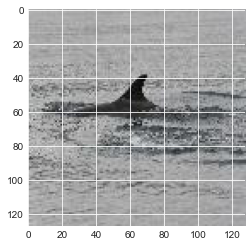

In [3]:
image = Image.open("dataset/train/0-100.jpg")
fig = plt.figure()
plt.imshow(image)

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
image = transform(image)
image = image.unsqueeze(0)  # add the batch dimension
image.shape

torch.Size([1, 3, 128, 128])

In [5]:
patch_size = 32
patches = rearrange(image, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
print(patches.shape)

torch.Size([1, 16, 3072])


In [6]:
a = nn.Linear(3072, 512)
out = a(patches)
print(out.shape)

torch.Size([1, 16, 512])


## ViT

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, image_size, embed_size):
        super().__init__()
        self.patch_embed = nn.Sequential(
            # use the conv layer instead of the linear layer for better performance 
            nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        # class embedding
        self.cls_token = nn.Parameter(torch.rand((1, embed_size)))
        # position embedding
        self.position_token = nn.Parameter(torch.rand(((image_size//patch_size)**2+1, embed_size)))
        
    def forward(self, x):
        b,_,_,_ = x.shape
        out = self.patch_embed(x)
        
        # concat class token
        cls_tokens = repeat(self.cls_token, 'h e -> b h e', b=b)
        out = torch.cat([cls_tokens, out], dim=1)
        # add position token
        out = out + self.position_token
        
        return out


x = torch.rand((2, 3, 128, 128))
PE = PatchEmbedding(3, 32, 128, 3072)
x = PE(x)
x.shape
        

torch.Size([2, 17, 3072])

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super().__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.querys = nn.Linear(self.embed_size, self.embed_size)
        self.keys = nn.Linear(self.embed_size, self.embed_size)
        self.values = nn.Linear(self.embed_size, self.embed_size)
        self.out_project = nn.Linear(self.embed_size, self.embed_size)
    
    def forward(self, x):
        # get the 8 keys, querys, and values
        # b: batch size  p: number of patches
        # c: changed embed size (one query vector dimension)  h: number of heads
        keys = rearrange(self.keys(x), 'b p (h c) -> b h p c', h=self.num_heads)
        querys = rearrange(self.querys(x), 'b p (h c) -> b h p c', h=self.num_heads)
        values = rearrange(self.values(x), 'b p (h c) -> b h p c', h=self.num_heads)
        # softmax of q \dot key.T
        # b: batch size   h: number of heads   
        # c: changed embed size (one query vector dimension) 
        # q: query patch numbers   k: keys patch numbers
        softmax_in = torch.einsum('b h q c, b h k c -> b h q k', querys, keys)
        softmax_divider = np.sqrt(self.embed_size)
        softmax_out = F.softmax(softmax_in, dim=-1) / softmax_divider
        # get the outputs
        # b: batch size   h: number of heads
        # c: changed embed size (one query vector dimension)
        out = torch.einsum('b h s p, b h p c -> b h s c', softmax_out, values)
        # b: batch size  p: number of patches  h: number of heads
        # c: changed embed size (one query vector dimension)
        out = rearrange(out, 'b h p c -> b p (h c)')
        out = self.out_project(out)
        
        return out
    
SA = SelfAttention(3072, 8)
x = SA(x)
x.shape

torch.Size([2, 17, 3072])

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self, SA, embed_size, num_heads, expan, drop_p: float = 0.):
        super().__init__()
        self.self_att = SA(embed_size, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, embed_size*expan),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(embed_size*expan, embed_size),
        )
        self.norm = nn.LayerNorm(embed_size)
        
    def forward(self, x):
        # first residual connection
        identity1 = x
        x = self.norm(x)
        x = self.self_att(x)
        x = x + identity1
        # second residual connection
        identity2 = x
        x = self.norm(x)
        x = self.mlp(x)
        x = x + identity2
        
        return x
        

In [6]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_size, class_num):
        super().__init__()
        self.cls = nn.Sequential(
            # Rarrange('b n e -> b (n e)')
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, class_num),
        )
        
    def forward(self, x):
        x = self.cls(x)
        return x


In [7]:
Parts = []
Parts.append(PatchEmbedding)
Parts.append(SelfAttention)
Parts.append(TransformerEncoder)
Parts.append(ClassificationHead)
print(Parts)

[<class '__main__.PatchEmbedding'>, <class '__main__.SelfAttention'>, <class '__main__.TransformerEncoder'>, <class '__main__.ClassificationHead'>]


In [8]:
class ViT(nn.Module):
    def __init__(self, Parts, in_channels, patch_size, image_size, cls_num, heads_num):
        super().__init__()
        self.embed_size = ((image_size // patch_size)**2)*in_channels
        # Patch Embedding
        self.PE = Parts[0](in_channels, patch_size, image_size, self.embed_size)
        # Transformer Encoder
        self.TF = Parts[2](Parts[1], self.embed_size, heads_num, 4)
        # Classification Head
        self.CLS = Parts[3](self.embed_size, cls_num)
        
    def forward(self, x):
        x = self.PE(x)
        for i in range (12):
            x = self.TF(x)
        x = self.CLS(x)
        return x


images = torch.rand((16, 3, 128, 128))
model = ViT(Parts, 3, 32, 128, 2, 8)
out = model(images)
print(out.shape)

torch.Size([16, 2])


### Data Loader

In [9]:
# data loader
class whale_dolphin(Dataset):
    def __init__(self, root, train=True):
        train_imgs = []
        val_imgs = []
        for path in os.listdir(root):
            label = int(path[:1])
            path_lst = path.split(".")
            if int(path_lst[0][2:]) < 1301:
                train_imgs.append((os.path.join(root, path), label))
            else:
                val_imgs.append((os.path.join(root, path), label))
        self.imgs = train_imgs if train else val_imgs
        self.transforms = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img_path = self.imgs[index][0]
        img_label = self.imgs[index][1]
        img_data = Image.open(img_path)
        img_data = self.transforms(img_data)
        return img_data, img_label


# This this the data loader for test set
class whale_dolphin_test(Dataset):
    def __init__(self, root):
        self.imgs = []
        for path in os.listdir(root):
            label = int(path[:1])
            path_lst = path.split(".")
            self.imgs.append((os.path.join(root, path), label))
        self.transforms = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img_path = self.imgs[index][0]
        img_label = self.imgs[index][1]
        img_data = Image.open(img_path)
        img_data = self.transforms(img_data)
        return img_data, img_label


In [26]:
root = 'dataset/train'
train_dataset = whale_dolphin(root, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for data, label in train_dataloader:
    print(data.shape)
    print(len(label))
    break

torch.Size([64, 3, 128, 128])
64


### Training

In [87]:
def main():
    # 1. load dataset
    root = 'dataset/train'
    batch_size = 64
    train_data = whale_dolphin(root, train=True)
    val_data = whale_dolphin(root, train=False)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    # 2.load model
    num_classes = 2
    img_channels = 3
    img_size = 128
    heads_num = 8
    patch_size = 32
    model = ViT(Parts, img_channels, patch_size, img_size, num_classes, heads_num)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cup')
    model = model.to(device)
    
    # 3.prepare hyperparameters
    criterion = nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epochs = 20
    
    # 4.train
    val_acc_list = []
    out_dir = "results/"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}")
        model.train()
        sum_loss = 0.0
        correct = 0.0
        total = 0.0
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            length = len(train_dataloader)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # torch.size([batch_size, num_class])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()
                print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                  % (epoch + 1, (batch_idx + 1 + epoch * length), sum_loss / (batch_idx + 1), 100. * correct / total))

        print("Waiting Val...")
        with torch.no_grad():
            correct = 0.0
            total = 0.0
            for batch_idx, (images, labels) in enumerate(val_dataloader):
                model.eval()
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum()

            print('Val\'s ac is: %.3f%%' % (100 * correct / total))

            acc_val = 100. * correct / total
            val_acc_list.append(acc_val)

        torch.save(model.state_dict(), out_dir + "last.pt")
        if acc_val == max(val_acc_list):
            torch.save(model.state_dict(), out_dir + "best.pt")
            print(f"save epoch {epoch} model")
    
    
main()


Epoch 1
[epoch:1, iter:1] Loss: 0.730 | Acc: 50.000% 
[epoch:1, iter:2] Loss: 0.728 | Acc: 56.250% 
[epoch:1, iter:3] Loss: 0.723 | Acc: 53.125% 
[epoch:1, iter:4] Loss: 0.718 | Acc: 53.125% 
[epoch:1, iter:5] Loss: 0.715 | Acc: 53.438% 
[epoch:1, iter:6] Loss: 0.719 | Acc: 52.344% 
[epoch:1, iter:7] Loss: 0.717 | Acc: 51.339% 
[epoch:1, iter:8] Loss: 0.713 | Acc: 51.758% 
[epoch:1, iter:9] Loss: 0.711 | Acc: 51.389% 
[epoch:1, iter:10] Loss: 0.710 | Acc: 51.094% 
[epoch:1, iter:11] Loss: 0.706 | Acc: 51.989% 
[epoch:1, iter:12] Loss: 0.704 | Acc: 52.344% 
[epoch:1, iter:13] Loss: 0.703 | Acc: 52.404% 
[epoch:1, iter:14] Loss: 0.702 | Acc: 52.232% 
[epoch:1, iter:15] Loss: 0.701 | Acc: 52.188% 
[epoch:1, iter:16] Loss: 0.700 | Acc: 51.953% 
[epoch:1, iter:17] Loss: 0.698 | Acc: 52.665% 
[epoch:1, iter:18] Loss: 0.700 | Acc: 51.649% 
[epoch:1, iter:19] Loss: 0.700 | Acc: 51.398% 
[epoch:1, iter:20] Loss: 0.699 | Acc: 51.719% 
[epoch:1, iter:21] Loss: 0.697 | Acc: 51.711% 
[epoch:1, ite

[epoch:5, iter:170] Loss: 0.552 | Acc: 74.479% 
[epoch:5, iter:171] Loss: 0.541 | Acc: 75.446% 
[epoch:5, iter:172] Loss: 0.525 | Acc: 76.758% 
[epoch:5, iter:173] Loss: 0.532 | Acc: 75.868% 
[epoch:5, iter:174] Loss: 0.524 | Acc: 76.094% 
[epoch:5, iter:175] Loss: 0.528 | Acc: 75.568% 
[epoch:5, iter:176] Loss: 0.531 | Acc: 75.260% 
[epoch:5, iter:177] Loss: 0.535 | Acc: 74.880% 
[epoch:5, iter:178] Loss: 0.540 | Acc: 74.442% 
[epoch:5, iter:179] Loss: 0.540 | Acc: 74.375% 
[epoch:5, iter:180] Loss: 0.534 | Acc: 75.000% 
[epoch:5, iter:181] Loss: 0.542 | Acc: 74.265% 
[epoch:5, iter:182] Loss: 0.537 | Acc: 74.826% 
[epoch:5, iter:183] Loss: 0.535 | Acc: 74.918% 
[epoch:5, iter:184] Loss: 0.534 | Acc: 74.844% 
[epoch:5, iter:185] Loss: 0.534 | Acc: 74.851% 
[epoch:5, iter:186] Loss: 0.534 | Acc: 74.858% 
[epoch:5, iter:187] Loss: 0.537 | Acc: 74.660% 
[epoch:5, iter:188] Loss: 0.539 | Acc: 74.544% 
[epoch:5, iter:189] Loss: 0.538 | Acc: 74.562% 
[epoch:5, iter:190] Loss: 0.539 | Acc: 7

[epoch:9, iter:337] Loss: 0.508 | Acc: 75.694% 
[epoch:9, iter:338] Loss: 0.506 | Acc: 75.625% 
[epoch:9, iter:339] Loss: 0.507 | Acc: 75.284% 
[epoch:9, iter:340] Loss: 0.509 | Acc: 75.260% 
[epoch:9, iter:341] Loss: 0.507 | Acc: 75.601% 
[epoch:9, iter:342] Loss: 0.514 | Acc: 75.335% 
[epoch:9, iter:343] Loss: 0.513 | Acc: 75.729% 
[epoch:9, iter:344] Loss: 0.515 | Acc: 75.781% 
[epoch:9, iter:345] Loss: 0.517 | Acc: 75.460% 
[epoch:9, iter:346] Loss: 0.515 | Acc: 75.434% 
[epoch:9, iter:347] Loss: 0.510 | Acc: 75.822% 
[epoch:9, iter:348] Loss: 0.509 | Acc: 75.938% 
[epoch:9, iter:349] Loss: 0.506 | Acc: 76.265% 
[epoch:9, iter:350] Loss: 0.508 | Acc: 76.065% 
[epoch:9, iter:351] Loss: 0.506 | Acc: 76.155% 
[epoch:9, iter:352] Loss: 0.503 | Acc: 76.172% 
[epoch:9, iter:353] Loss: 0.504 | Acc: 76.062% 
[epoch:9, iter:354] Loss: 0.506 | Acc: 75.901% 
[epoch:9, iter:355] Loss: 0.507 | Acc: 75.752% 
[epoch:9, iter:356] Loss: 0.506 | Acc: 75.725% 
[epoch:9, iter:357] Loss: 0.507 | Acc: 7

[epoch:13, iter:501] Loss: 0.435 | Acc: 78.819% 
[epoch:13, iter:502] Loss: 0.440 | Acc: 78.906% 
[epoch:13, iter:503] Loss: 0.449 | Acc: 78.551% 
[epoch:13, iter:504] Loss: 0.448 | Acc: 78.516% 
[epoch:13, iter:505] Loss: 0.446 | Acc: 78.606% 
[epoch:13, iter:506] Loss: 0.440 | Acc: 78.906% 
[epoch:13, iter:507] Loss: 0.439 | Acc: 78.958% 
[epoch:13, iter:508] Loss: 0.437 | Acc: 78.711% 
[epoch:13, iter:509] Loss: 0.436 | Acc: 78.585% 
[epoch:13, iter:510] Loss: 0.439 | Acc: 78.646% 
[epoch:13, iter:511] Loss: 0.448 | Acc: 77.714% 
[epoch:13, iter:512] Loss: 0.448 | Acc: 78.047% 
[epoch:13, iter:513] Loss: 0.448 | Acc: 78.274% 
[epoch:13, iter:514] Loss: 0.449 | Acc: 78.267% 
[epoch:13, iter:515] Loss: 0.450 | Acc: 78.057% 
[epoch:13, iter:516] Loss: 0.450 | Acc: 77.995% 
[epoch:13, iter:517] Loss: 0.447 | Acc: 78.188% 
[epoch:13, iter:518] Loss: 0.452 | Acc: 78.185% 
[epoch:13, iter:519] Loss: 0.450 | Acc: 78.356% 
[epoch:13, iter:520] Loss: 0.452 | Acc: 78.348% 
[epoch:13, iter:521]

[epoch:17, iter:665] Loss: 0.420 | Acc: 80.208% 
[epoch:17, iter:666] Loss: 0.426 | Acc: 79.844% 
[epoch:17, iter:667] Loss: 0.418 | Acc: 80.398% 
[epoch:17, iter:668] Loss: 0.427 | Acc: 79.818% 
[epoch:17, iter:669] Loss: 0.425 | Acc: 79.808% 
[epoch:17, iter:670] Loss: 0.421 | Acc: 80.134% 
[epoch:17, iter:671] Loss: 0.424 | Acc: 80.104% 
[epoch:17, iter:672] Loss: 0.423 | Acc: 80.273% 
[epoch:17, iter:673] Loss: 0.422 | Acc: 79.871% 
[epoch:17, iter:674] Loss: 0.422 | Acc: 79.774% 
[epoch:17, iter:675] Loss: 0.419 | Acc: 80.016% 
[epoch:17, iter:676] Loss: 0.419 | Acc: 80.156% 
[epoch:17, iter:677] Loss: 0.419 | Acc: 80.060% 
[epoch:17, iter:678] Loss: 0.419 | Acc: 79.688% 
[epoch:17, iter:679] Loss: 0.418 | Acc: 79.755% 
[epoch:17, iter:680] Loss: 0.417 | Acc: 79.818% 
[epoch:17, iter:681] Loss: 0.415 | Acc: 79.938% 
[epoch:17, iter:682] Loss: 0.414 | Acc: 79.988% 
[epoch:17, iter:683] Loss: 0.416 | Acc: 79.861% 
[epoch:17, iter:684] Loss: 0.417 | Acc: 79.967% 
[epoch:17, iter:685]

## Test

In [10]:
model = ViT(Parts, 3, 32, 128, 2, 8)
model.load_state_dict(torch.load("results/vit-best.pt"))
model = model.to('cuda')
model.eval()

ViT(
  (PE): PatchEmbedding(
    (patch_embed): Sequential(
      (0): Conv2d(3, 48, kernel_size=(32, 32), stride=(32, 32))
      (1): Rearrange('b e (h) (w) -> b (h w) e')
    )
  )
  (TF): TransformerEncoder(
    (self_att): SelfAttention(
      (querys): Linear(in_features=48, out_features=48, bias=True)
      (keys): Linear(in_features=48, out_features=48, bias=True)
      (values): Linear(in_features=48, out_features=48, bias=True)
      (out_project): Linear(in_features=48, out_features=48, bias=True)
    )
    (mlp): Sequential(
      (0): Linear(in_features=48, out_features=192, bias=True)
      (1): GELU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=192, out_features=48, bias=True)
    )
    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  )
  (CLS): ClassificationHead(
    (cls): Sequential(
      (0): Reduce('b n e -> b e', 'mean')
      (1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=48, out_fe

In [11]:
def predict(input, model):
  with torch.no_grad():
    out = model(input)
    _, pre = torch.max(out.data, 1)
    return pre.item()

In [12]:
transform = transforms.Compose([transforms.ToTensor()])
image = Image.open("dataset/train/0-100.jpg")
image = transform(image).reshape((1, 3, 128, 128)).to('cuda')
out = predict(image, model)
print(f"Prediction of the image is: {out}")

Prediction of the image is: 0


In [14]:
def test(model):
    # 1.load the model
    model = model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cup')
    model = model.to(device)
    model.eval()

    # 2.load the test data
    root = "dataset/test"
    batch_size = 64
    test_data = whale_dolphin_test(root)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    # 3.test
    print("Waiting Test...")
    with torch.no_grad():
        correct = 0
        total = 0
        for (images, labels) in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            out = model(images)
            _, pre = torch.max(out.data, 1)
            total += labels.size(0)   # why use (0) not [0]???
            correct += (pre == labels).sum().item()
        print(f"The Accuracy is: {correct/total}")


test(model)

Waiting Test...
The Accuracy is: 0.793


## Visualization

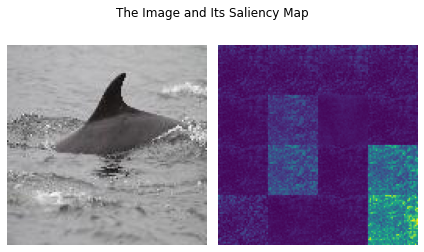

In [32]:
def saliency_map(image_path, transform, model):

    # preprocess the image
    transform = transforms.Compose([transforms.ToTensor()])
    image = Image.open(image_path)
    image = transform(image).reshape((1, 3, 128, 128)).to('cuda')

    # require gradient
    image.requires_grad_()

    # get the output
    output = model(image)
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # backpropagation to get the derivative of the output based on the image
    output_max.backward()

    # get the graident. Question: Add the .abs()???????
    # dimension: (batch_size, channel, width, height), get the max value along the channels
    saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
    saliency = saliency.reshape(128, 128)

    # reshape the saliency vector to image
    image = image.reshape(-1, 128, 128)

    # visualization
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(saliency.cpu())
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()
saliency_map("dataset/train/0-233.jpg", transform, model)